# Transient Heat Equation: Extended with Non-Linear Dirichtlet Boundary Conditions 

## Import Packages 

In [1]:
using Pkg
Pkg.activate("C:\\Users\\anouc\\.julia\\environments\\v1.11")

  Activating project at `C:\Users\anouc\.julia\environments\v1.11`


In [2]:
using Ferrite
using SparseArrays
using LinearAlgebra         # provides mul! 
using UnPack                # added for time integration using DifferentialEquations.jl 
using OrdinaryDiffEq        # added for time integration using DifferentialEquations.jl
using DifferentialEquations # added for time integration using DifferentialEquations.jl   

In [3]:
using WriteVTK
using Plots                 # provides contour plot of cell averages 
using NLSolvers
using ForwardDiff
using Printf   

In [4]:
?generate_grid

search: generate_grid @generated Pkg.generate Base.Generator



```
generate_grid(celltype::Cell, nel::NTuple, [left::Vec, right::Vec)
```

Return a `Grid` for a rectangle in 1, 2 or 3 dimensions. `celltype` defined the type of cells, e.g. `Triangle` or `Hexahedron`. `nel` is a tuple of the number of elements in each direction. `left` and `right` are optional endpoints of the domain. Defaults to -1 and 1 in all directions.


## Section 1: 1D Heat Equation Linear BC

### Section 1.1: Model Problem 

We are solving the 1D transient heat equation, which describes the evolution of temperature $u(x,t)$ over time and space.

$$\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2} + f(x,t) $$

* **Source Term:** $f(x,t) = 1-x$ in the whole domain.

* **Thermal Diffusivity:** The thermal diffusivity of the material is $D=1$.


The simulation is performed on a **linear domain** (e.g., a unit line segment $[0,1]$).



**Initial Condition:**
    $$u(x,0) = 0 \quad \text{for all } x \text{ in the domain}$$



**Boundary Conditions (BCs)**

* **Right Boundary ($x=1$):**
    The temperature is fixed at zero at the right end.
    $$u(1,t) = 0$$

* **Left Boundary ($x=0$, Time-Dependent):**
    The temperature at the left boundary (`x=0`) follows a time-dependent relationship. This condition ensures that the temperature starts at zero at $t=0$ (to be consistent with the initial condition).
        $$u(0,t) = t$$

### Section 1.2: Spatial Dicretization 

In [5]:
# --- 1. Définition du maillage et des fonctions de forme ---
nels = (40,)
left = Vec((0.,))
right = Vec((1.,))
grid = generate_grid(Line, nels, left, right)

ip = Lagrange{Ferrite.RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cellvalues = CellValues(qr, ip)

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh)

# --- 2. Allocation des matrices prototypes ---

K_prototype = allocate_matrix(dh)
M_prototype = allocate_matrix(dh)

# --- 3. Conditions aux limites ---

ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")

add!(ch, Dirichlet(:u, left_boundary, (x, t) -> t)) 
add!(ch, Dirichlet(:u, right_boundary, (x, t) -> 0.0))
close!(ch)

update!(ch, 0.0);

# --- 4. Assemblage local et global ---

function assemble_element!(Ke, fe, cellvalues, cell_coords, t)
    n = getnbasefunctions(cellvalues)
    fill!(Ke, 0.0)
    fill!(fe, 0.0)
    for q in 1:getnquadpoints(cellvalues)
        dΩ = getdetJdV(cellvalues, q)
        x = spatial_coordinate(cellvalues, q, cell_coords)[1]
        f_val = 1.0 - x
        for i in 1:n, j in 1:n
            ∇ϕ_i = shape_gradient(cellvalues, q, i)[1]
            ∇ϕ_j = shape_gradient(cellvalues, q, j)[1]
            Ke[i, j] += ∇ϕ_i * ∇ϕ_j * dΩ
        end
        for i in 1:n
            ϕ_i = shape_value(cellvalues, q, i)
            fe[i] += ϕ_i * f_val * dΩ
        end
    end
end

function assemble_global_Kf(cellvalues, K_proto, dh, t)
    Ke = zeros(getnbasefunctions(cellvalues), getnbasefunctions(cellvalues))
    fe = zeros(getnbasefunctions(cellvalues))
    f = zeros(ndofs(dh))
    K = copy(K_proto)
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        assemble_element!(Ke, fe, cellvalues, getcoordinates(cell), t)
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

function assemble_M!(M_proto, cellvalues, dh)
    n = getnbasefunctions(cellvalues)
    Me = zeros(n, n)
    assembler = start_assemble(M_proto)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        fill!(Me, 0.0)
        for q in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q)
            for i in 1:n
                ϕ_i = shape_value(cellvalues, q, i)
                for  j in 1:n
                    ϕ_j = shape_value(cellvalues, q, j)
                    Me[i, j] += ϕ_i * ϕ_j * dΩ
                end
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M_proto
end

M_global = assemble_M!(M_prototype, cellvalues, dh);


### Section 1.3 Time Integration Using DifferentialEquations.jl

In [7]:
# --- 5. Définition de l’équation ODE ---

function heat_equation_ode!(du, u, p, t)
    K_proto, M_global, dh, cellvalues, ch = p
    K, f = assemble_global_Kf(cellvalues, K_proto, dh, t)
    update!(ch, t);
    apply!(K, f, ch)
    du .= M_global \ (f - K * u)
end

# --- 6. Condition initiale ---

u0 = zeros(ndofs(dh))

# --- 7. Intervalle de simulation ---

tspan = (0.0, 10.0)

# --- 8. Définition du problème et résolution ---

params = (K_prototype, M_global, dh, cellvalues, ch)
prob = ODEProblem(heat_equation_ode!, u0, tspan, params)
sol = DifferentialEquations.solve(prob, Tsit5(), saveat=0.5);

### Section 1.4 Validation of Results

The analytical solution $u(x,t) = t(1-x)$ satisfies the governing partial differential equation, the initial condition, and both boundary conditions:

$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + (1-x)$$

Let's compute the derivatives of our proposed solution $u(x,t) = t(1-x)$:

$$\frac{\partial u}{\partial t} = \frac{\partial}{\partial t} [t(1-x)] = 1-x$$

$$\frac{\partial u}{\partial x} = \frac{\partial}{\partial x} [t(1-x)] = -t$$
$$\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x} [-t] = 0$$

Now, substitute these derivatives back into the governing equation:

$$(1-x) = (0) + (1-x)$$
$$1-x = 1-x$$

The governing equation is satisfied.

**Initial Condition**

The initial condition is $u(x,0) = 0$ for all $x$ in the domain.

Let's evaluate our solution $u(x,t) = t(1-x)$ at $t=0$:

$$u(x,0) = 0 \cdot (1-x) = 0$$

The initial condition is satisfied.

**Right Boundary ($x=1$):**

The boundary condition at the right end is $u(1,t) = 0$.

Let's evaluate our solution $u(x,t) = t(1-x)$ at $x=1$:

$$u(1,t) = t(1-1) = t \cdot 0 = 0$$

The right boundary condition is satisfied.

**Left Boundary ($x=0$, Time-Dependent):**

The boundary condition at the left end is $u(0,t) = t$.

Let's evaluate our solution $u(x,t) = t(1-x)$ at $x=0$:

$$u(0,t) = t(1-0) = t \cdot 1 = t$$

The left boundary condition is satisfied.

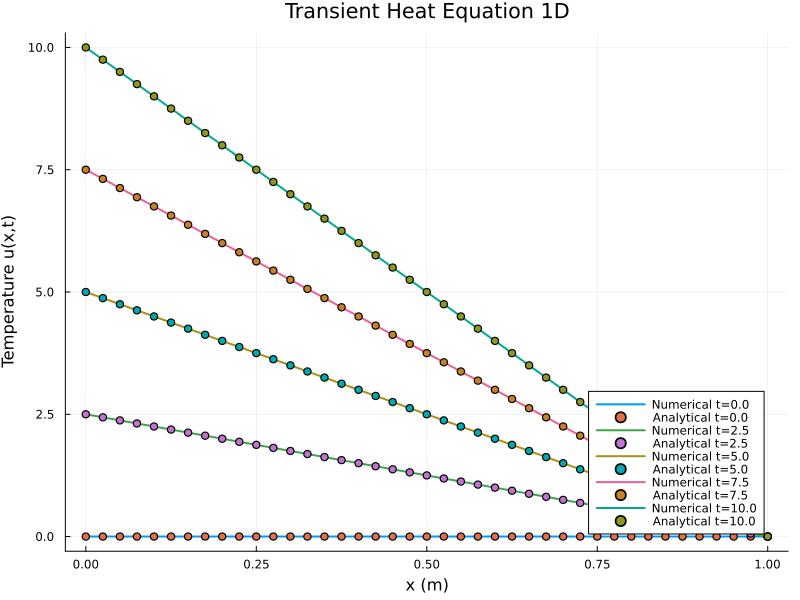

In [8]:
# --- 9. Visualisation ---

node_coords = [x.x[1] for x in getnodes(grid)]
analytical_solution(x, t) = t * (1.0 - x)

plt = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Transient Heat Equation 1D", 
           legend=:bottomright, size=(800,600))


# Choisir 5 indices répartis uniformément dans le vecteur de temps
n_times = 5
indices = round.(Int, range(1, length(sol.t), length=n_times))

for i in indices
    t_val = sol.t[i]
    u_num = sol.u[i]
    plot!(plt, node_coords, u_num, label="Numerical t=$(round(t_val, digits=2))", lw=2)
    scatter!(plt, node_coords, analytical_solution.(node_coords, t_val), label="Analytical t=$(round(t_val, digits=2))", lw=2, ls=:dash)
end

display(plt)

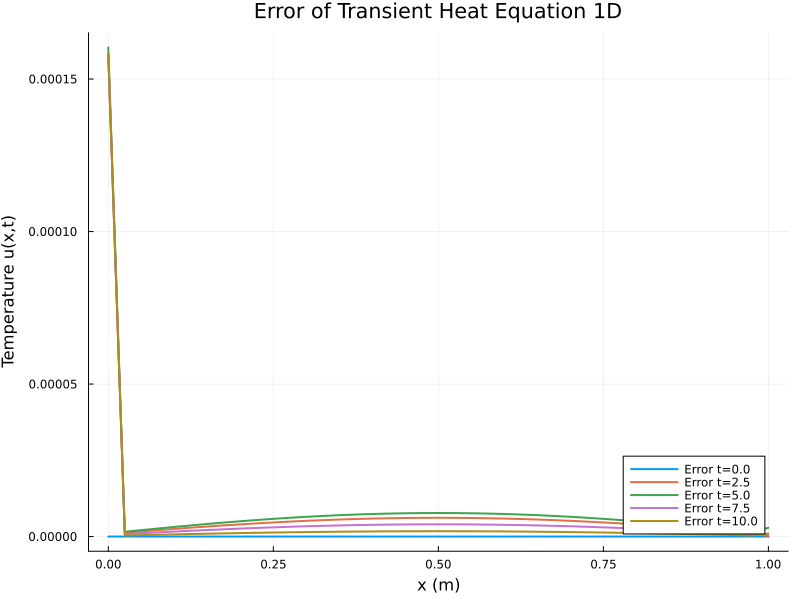

In [9]:
plt_error = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Error of Transient Heat Equation 1D", 
           legend=:bottomright, size=(800,600))

for i in indices
    t_val = sol.t[i]
    u_num = sol.u[i]
    plot!(plt_error, node_coords, abs.(u_num .- analytical_solution.(node_coords, t_val)), label="Error t=$(round(t_val, digits=2))", lw=2)
end

display(plt_error)


## Section 2: 1D Heat Equation Non Linear BC

### Section 2.1 Problem Formulation


We are solving the 1D transient heat equation, which describes the evolution of temperature $u(x,t)$ over time and space.
    $$\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2} + f(x,t)$$
    where $\frac{\partial^2 u}{\partial x^2}$ is the second spatial derivative of $u$ with respect to $x$.

* Thermal Diffusivity: $D=1$.
* Source Term: $f(x,t) = 10(1-x)$.


The simulation is performed on a **linear domain** (a unit line segment $[0,1]$).


**Initial Condition:**
    $$u(x,0) = 0 \quad \text{for all } x \in [0,1]$$

**Boundary Condition:**

* *Right Boundary ($x=1$):*
    The temperature is fixed at zero at the right end.
    $$u(1,t) = 0$$

* *Left Boundary ($x=0$, Nonlinear and Time-Dependent):*
    The temperature at the left boundary (`x=0`) follows a nonlinear and time-dependent relationship. This condition ensures that the temperature starts at zero at $t=0$ (to be consistent with the initial condition) and ramps up smoothly.
        $$u(0,t)^2 = 100t^2$$

### Section 2.2 Spatial Discretization

In [24]:
# --- 1. Définition du maillage et des fonctions de forme ---

nels = (80,)
left = Vec((0.,))
right = Vec((1.,))
grid = generate_grid(Line, nels, left, right)

ip = Lagrange{RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cellvalues = CellValues(qr, ip)

fqr = FacetQuadratureRule{RefLine}(2) # Règle de quadrature pour les facettes
fvu = FacetValues(fqr, ip) # Objet pour les calculs sur les facettes

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh)

# --- 2. Allocation des matrices prototypes ---

K_prototype = allocate_matrix(dh)
M_prototype = allocate_matrix(dh)

# --- 3. Conditions aux limites ---

ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")

#add!(ch, Dirichlet(:u, left_boundary, (x, t) -> t))                  # !!!!!!!!!!!!!!!!!!!!!!! Modification avec Section 1
add!(ch, Dirichlet(:u, right_boundary, (x, t) -> 0.0))
close!(ch)

update!(ch, 0.0);

# --- 4. Assemblage local et global ---

function assemble_element!(Ke, fe, cellvalues, cell_coords)
    n = getnbasefunctions(cellvalues)
    fill!(Ke, 0.0)
    fill!(fe, 0.0)
    for q in 1:getnquadpoints(cellvalues)
        dΩ = getdetJdV(cellvalues, q)
        x = spatial_coordinate(cellvalues, q, cell_coords)[1]
        f_val = 10*(1.0 - x)                                          #  !!!!!!!!!!!!!!!!!!!!!!! Modification avec Section 1
        for i in 1:n, j in 1:n
            ∇ϕ_i = shape_gradient(cellvalues, q, i)[1]
            ∇ϕ_j = shape_gradient(cellvalues, q, j)[1]
            Ke[i, j] += ∇ϕ_i * ∇ϕ_j * dΩ
        end
        for i in 1:n
            ϕ_i = shape_value(cellvalues, q, i)
            fe[i] += ϕ_i * f_val * dΩ
        end
    end
end

function assemble_global_Kf(cellvalues, K_proto, dh)
    Ke = zeros(getnbasefunctions(cellvalues), getnbasefunctions(cellvalues))
    fe = zeros(getnbasefunctions(cellvalues))
    f = zeros(ndofs(dh))
    K = copy(K_proto)
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        assemble_element!(Ke, fe, cellvalues, getcoordinates(cell))
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

function assemble_M!(M_proto, cellvalues, dh)
    n = getnbasefunctions(cellvalues)
    Me = zeros(n, n)
    assembler = start_assemble(M_proto)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        fill!(Me, 0.0)
        for q in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q)
            for i in 1:n
                ϕ_i = shape_value(cellvalues, q, i)
                for  j in 1:n
                    ϕ_j = shape_value(cellvalues, q, j)
                    Me[i, j] += ϕ_i * ϕ_j * dΩ
                end
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M_proto
end

M_global = assemble_M!(M_prototype, cellvalues, dh);


### Section 2.3 Non Linear BC Functions and ODE

In [25]:
# --- !!!!!!!!! 5. Fonctions pour la Condition aux Limites Non Linéaire ---

# Target value for the nonlinear BC: u(0,t)^2 = 100t^2
TargetValue(t) = 100.0 * t^2
res_functional(u_val, t) = u_val^2 - TargetValue(t)
dures_functional(u_val) = 2.0 * u_val

# Fonction pour assembler la contribution du résidu de la CL non linéaire
function assemble_nonlinear_bc_residual!(R_bc::Vector, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    re_bc = zeros(n_basefuncs_facet) # Résidu local pour la CL (taille des DOFs de la facette)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet) # Réinitialise fvu pour la facette actuelle
        
        facet_dof = celldofs(facet)[1] # DOF global de la facette
        u_facet_val = u_current[facet_dof] # Valeur de u au DOF de la facette

        fill!(re_bc, 0.0) # Réinitialise le résidu local pour cette facette

        for qp in 1:getnquadpoints(fvu) # En 1D, une facette est un point, donc 1 point de quadrature
            dΓ = getdetJdV(fvu, qp) # Élément de surface pondéré (longueur ici)
      
            u_qp = u_facet_val # La valeur de u au point de quadrature est la valeur nodale elle-même

            # Valeur du résidu de la CL non linéaire au point de quadrature
            val_qp = res_functional(u_qp, t)

            for i in 1:n_basefuncs_facet # n_basefuncs_facet est 1 pour un nœud en 1D
                ϕ_i = shape_value(fvu, qp, i) # Fonction de forme test locale de la facette (vaut 1 au nœud)
                re_bc[i] -= val_qp * ϕ_i * dΓ
            end
        end
        # Assemble le résidu local de la CL dans le vecteur global R_bc
        assemble!(R_bc, celldofs(facet), re_bc)
    end
end

assemble_nonlinear_bc_residual! (generic function with 1 method)

In [27]:
# --- 6. Définition de l’équation ODE ---

# Structure pour passer les paramètres à l'ODE
struct NLparams
    K_prototype::SparseMatrixCSC{Float64, Int}
    M_global::SparseMatrixCSC{Float64, Int}
    dh::DofHandler
    cellvalues::CellValues
    ch::ConstraintHandler # Contient seulement les CL linéaires
    fvu::FacetValues # Pour les CL de facettes
    left_boundary_set # Pour la boucle sur le bord gauche
    K_buffer::SparseMatrixCSC{Float64, Int}
    f_buffer::Vector{Float64}               
end


function heat_equation_ode!(du, u_current, p::NLparams, t)
    @unpack K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary_set, K_buffer, f_buffer = p 
    
    update!(ch, t) 
    apply!(K_buffer, f_buffer, ch) 
    
    R_total = copy(f_buffer) 
    mul!(R_total, K_buffer, u_current, -1.0, 1.0) 
    
    assemble_nonlinear_bc_residual!(R_total, u_current, dh, fvu, left_boundary_set, t)

    # 5. Résoudre pour du/dt: M * du/dt = R_total => du/dt = M \ R_total
    du .= M_global \ R_total
end

# --- 7. Condition initiale ---

u0 = zeros(ndofs(dh)) # u(x,0) = 0 partout

# --- 8. Intervalle de simulation ---

tspan = (0.0, 10.0) # Temps de simulation

# --- 9. Définition du problème et résolution ---

initial_K_buffer, initial_f_buffer = assemble_global_Kf(cellvalues, K_prototype, dh) 
params = NLparams(K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary, initial_K_buffer, initial_f_buffer)

rhs_ode = ODEFunction(heat_equation_ode!)

# Définition du problème ODE
prob = ODEProblem(rhs_ode, u0, tspan, params)
sol_nl = DifferentialEquations.solve(prob, Tsit5(), reltol = 1e-5, abstol = 1e-5, saveat=0.1); 

### Section 2.4 Validation of Results

Based on the problem formulation, a simple analytical solution can be derived.

* *Analytical Solution:*
    $$u(x,t) = 10t(1-x)$$


* *Verification in the Equation* 

Left-Hand Side (LHS): $\frac{\partial u}{\partial t}$
    $$u(x,t) = 10t - 10tx$$
    $$\frac{\partial u}{\partial t} = \frac{\partial}{\partial t}(10t - 10tx) = 10 - 10x = 10(1-x)$$

Spatial derivative: $D\frac{\partial^2 u}{\partial x^2} + f(x,t)$
    First, calculate the spatial derivatives of $u(x,t)$:
    $$\frac{\partial u}{\partial x} = \frac{\partial}{\partial x}(10t - 10tx) = -10t$$
    $$\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x}(-10t) = 0$$
    Now, substitute into the RHS of the PDE:
    $$D\frac{\partial^2 u}{\partial x^2} + f(x,t) = (1) \cdot (0) + 10(1-x)$$
    $$= 0 + 10(1-x)$$
    $$= 10(1-x)$$

* *Verification of Boundary and Initial Conditions:*
    * At $x=0$: $u(0,t) = 10t(1-0) = 10t$. This satisfies the left boundary condition $u(0,t)^2 = (10t)^2 = 100t^2$.
    * At $x=1$: $u(1,t) = 10t(1-1) = 0$. This satisfies the right boundary condition.
    * At $t=0$: $u(x,0) = 10(0)(1-x) = 0$. This satisfies the initial condition.


In [ ]:
# --- 10. Visualisation ---

node_coords = [x.x[1] for x in getnodes(grid)]
analytical_solution_nl(x, t) = 10 * t * (1.0 - x)

plt_nl = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Transient Heat Equation 1D Non Linear BC", 
           legend=:bottomright, size=(800,600))


# Choisir 5 indices répartis uniformément dans le vecteur de temps
n_times = 5
indices = round.(Int, range(1, length(sol_nl.t), length=n_times))

for i in indices
    t_val = sol_nl.t[i]
    u_num_nl = sol_nl.u[i]
    plot!(plt_nl, node_coords, u_num_nl, label="Numerical t=$(round(t_val, digits=2))", lw=2)
    scatter!(plt_nl, node_coords, analytical_solution_nl.(node_coords, t_val), label="Analytical t=$(round(t_val, digits=2))", lw=2, ls=:dash)
end

display(plt_nl)

println(analytical_solution_nl(1, 10))
#println(sol_nl.t[101])
#println(sol_nl.u[10])

In [ ]:
plt_error_nl = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Error of Transient Heat Equation 1D Non Linear BC", 
           legend=:bottomright, size=(800,600))

for i in indices
    t_val = sol_nl.t[i]
    u_num_nl = sol_nl.u[i]
    plot!(plt_error_nl, node_coords, abs.(u_num_nl .- analytical_solution_nl.(node_coords, t_val)), label="Error t=$(round(t_val, digits=2))", lw=2)
end

display(plt_error_nl)

### Section 2.5 Convergence Study

In [ ]:
# --- Début de la boucle pour l'étude de convergence ---

# Maillages à tester
nels_values = [20, 50, 80, 110, 140, 160]

# Arrays pour stocker les résultats
u_at_x0_t10_values = Float64[]
num_elements = Int[]


for n_elem in nels_values
    @info "Résolution pour $(n_elem) éléments..."
    
    # --- 1. Définition du maillage et des fonctions de forme ---
    nels_current = (n_elem,)
    left = Vec((0.,))
    right = Vec((1.,))
    grid = generate_grid(Line, nels_current, left, right)

    ip = Lagrange{RefLine, 1}()
    qr = QuadratureRule{RefLine}(2)
    cellvalues = CellValues(qr, ip)

    dh = DofHandler(grid)
    add!(dh, :u, ip)
    close!(dh)

    # --- 2. Allocation des matrices prototypes (à réallouer pour chaque maillage) ---
    K_prototype = allocate_matrix(dh)
    M_prototype = allocate_matrix(dh)

    # --- 3. Conditions aux limites (à recréer pour chaque maillage) ---
    ch = ConstraintHandler(dh)
    left_boundary = getfacetset(grid, "left")
    right_boundary = getfacetset(grid, "right")

    add!(ch, Dirichlet(:u, right_boundary, (x, t) -> 0.0)) # CL de Dirichlet au bord droit
    close!(ch) 
    update!(ch, 0.0); # Mise à jour pour le temps initial

    # --- 4. Assemblage de la matrice de masse M_global (dépend du maillage) ---
    M_global = assemble_M!(M_prototype, cellvalues, dh);

    # --- 5. Condition initiale ---
    u0 = zeros(ndofs(dh)) # u(x,0) = 0 partout

    # --- 6. Intervalle de simulation ---
    tspan = (0.0, 10.0) # Temps de simulation

    # --- 7. Définition du problème et résolution de l'ODE ---
    params = NLparams(K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary) 
    rhs_ode = ODEFunction(heat_equation_ode!)
    prob = ODEProblem(rhs_ode, u0, tspan, params)
    
    # Résolution de l'ODE
    sol_nl = solve(prob, Tsit5(), reltol = 1e-5, abstol = 1e-5, saveat=0.1); 

    # --- 8. Extraction du résultat souhaité : u(x=0, au temps t=10) ---
    # Le nœud à x=0 est le premier nœud du maillage 1D de Ferrite.jl (DOF 1).
    # t=10 est le dernier point de temps sauvegardé par `saveat=0.1`.
    u_val_at_x0_t10 = sol_nl[end][1] 

    # Stocke les résultats
    push!(u_at_x0_t10_values, u_val_at_x0_t10)
    push!(num_elements, n_elem)
end

# --- 9. Tracé de la convergence ---
plt_convergence = plot(num_elements, u_at_x0_t10_values, 
                       marker=:circle, 
                       label="Numérique u(0, t=10)",
                       xlabel="Nombre d'éléments", 
                       ylabel="u(x=0, t=10)", 
                       title="Convergence de u(x=0, t=10) avec le raffinement du maillage",
                       legend=:bottomright,
                       size=(800,600))

display(plt_convergence)

## Section 3: 1D Heat Equation Non Linear BC With Jacobian

### Section 3.1 Strategy

In Section 2, we successfully solved the 1D transient heat equation with a nonlinear boundary condition using an explicit time integration method (`Tsit5`). This approach allowed us to focus solely on the `rhs` (right-hand side) function, which defines the physics of the problem.

While explicit methods are useful for initial analysis, implicit solvers often offer better stability and accuracy for stiff or nonlinear problems, especially when larger time steps are desired. Implicit solvers, however, require the Jacobian matrix of the `rhs` function.

The Jacobian matrix, $J = \frac{\partial R_{total}}{\partial U}$, describes how the residual vector $R_{total}$ changes with respect to changes in the solution vector $U$. For a system of ODEs written as $M \frac{dU}{dt} = R_{total}(U,t)$, an implicit solver will internally solve a nonlinear system, often using a Newton-Raphson-like method, which requires the Jacobian.

This section will demonstrate how to incorporate the Jacobian into our `DifferentialEquations.jl` setup.

There are two primary ways to provide the Jacobian:

1.  **Analytical Jacobian:** Manually derive and implement the exact partial derivatives. This is generally the most accurate and fastest method for large problems, but it can be tedious and error-prone for complex nonlinearities.
2.  **Automatic Differentiation (AD) / Finite Differences (FD):** Let the software compute the Jacobian numerically. This is simpler to implement but can be slower and less accurate than an analytical Jacobian.

Using this notebook: https://github.com/ziolai/finite_element_electrical_engineering/blob/main/project-based-assignment/metal-hydride-storage/notebooks/transient_1d_heat_transfer.ipynb we will implement our Jacobian analytically.

### Section 3.2 Numerical Implementation

Exact same code as in Section 2

In [46]:
# --- 1. Définition du maillage et des fonctions de forme ---

nels = (40,)
left = Vec((0.,))
right = Vec((1.,))
grid = generate_grid(Line, nels, left, right)

ip = Lagrange{RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cellvalues = CellValues(qr, ip)

fqr = FacetQuadratureRule{RefLine}(2) # Règle de quadrature pour les facettes
fvu = FacetValues(fqr, ip) # Objet pour les calculs sur les facettes

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh)

# --- 2. Allocation des matrices prototypes ---

K_prototype = allocate_matrix(dh)
M_prototype = allocate_matrix(dh)

# --- 3. Conditions aux limites ---

ch = ConstraintHandler(dh)
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")

dbc_right = Dirichlet(:u, right_boundary, (x, t) -> 0.0)                             
add!(ch, dbc_right)
close!(ch) 


# --- 4. Assemblage local et global ---

function assemble_element!(Ke, fe, cellvalues, cell_coords)
    n = getnbasefunctions(cellvalues)
    fill!(Ke, 0.0)
    fill!(fe, 0.0)
    for q in 1:getnquadpoints(cellvalues)
        dΩ = getdetJdV(cellvalues, q)
        x = spatial_coordinate(cellvalues, q, cell_coords)[1]
        f_val = 10 * (1.0 - x)
        for i in 1:n, j in 1:n
            ∇ϕ_i = shape_gradient(cellvalues, q, i)[1]
            ∇ϕ_j = shape_gradient(cellvalues, q, j)[1]
            Ke[i, j] += ∇ϕ_i * ∇ϕ_j * dΩ
        end
        for i in 1:n
            ϕ_i = shape_value(cellvalues, q, i)
            fe[i] += ϕ_i * f_val * dΩ
        end
    end
end

function assemble_global_Kf(cellvalues, K_proto, dh)
    Ke = zeros(getnbasefunctions(cellvalues), getnbasefunctions(cellvalues))
    fe = zeros(getnbasefunctions(cellvalues))
    f = zeros(ndofs(dh))
    K = copy(K_proto)
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        assemble_element!(Ke, fe, cellvalues, getcoordinates(cell))
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

function assemble_M!(M_proto, cellvalues, dh)
    n = getnbasefunctions(cellvalues)
    Me = zeros(n, n)
    assembler = start_assemble(M_proto)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        fill!(Me, 0.0)
        for q in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q)
            for i in 1:n
                ϕ_i = shape_value(cellvalues, q, i)
                for  j in 1:n
                    ϕ_j = shape_value(cellvalues, q, j)
                    Me[i, j] += ϕ_i * ϕ_j * dΩ
                end
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M_proto
end

M_global = assemble_M!(M_prototype, cellvalues, dh);

In [47]:
# --- 5. Fonctions pour la Condition aux Limites Non Linéaire ---

# Target value for the nonlinear BC: u(0,t)^2 = 100t^2
TargetValue(t) = 100.0 * t^2
res_functional(u_val, t) = u_val^2 - TargetValue(t)
dures_functional(u_val) = 2.0 * u_val

# Fonction pour assembler la contribution du résidu de la CL non linéaire
function assemble_nonlinear_bc_residual!(R_bc::Vector, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    re_bc = zeros(n_basefuncs_facet) # Résidu local pour la CL (taille des DOFs de la facette)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet) # Réinitialise fvu pour la facette actuelle
        
        facet_dof = celldofs(facet)[1] # DOF global de la facette
        u_facet_val = u_current[facet_dof] # Valeur de u au DOF de la facette

        fill!(re_bc, 0.0) # Réinitialise le résidu local pour cette facette

        for qp in 1:getnquadpoints(fvu) # En 1D, une facette est un point, donc 1 point de quadrature
            dΓ = getdetJdV(fvu, qp) # Élément de surface pondéré (longueur ici)
      
            u_qp = u_facet_val # La valeur de u au point de quadrature est la valeur nodale elle-même

            # Valeur du résidu de la CL non linéaire au point de quadrature
            val_qp = res_functional(u_qp, t)

            for i in 1:n_basefuncs_facet # n_basefuncs_facet est 1 pour un nœud en 1D
                ϕ_i = shape_value(fvu, qp, i) # Fonction de forme test locale de la facette (vaut 1 au nœud)
                re_bc[i] -= val_qp * ϕ_i * dΓ
            end
        end
        # Assemble le résidu local de la CL dans le vecteur global R_bc
        assemble!(R_bc, celldofs(facet), re_bc)
    end
end

assemble_nonlinear_bc_residual! (generic function with 1 method)

### Section 3.3 Jacobian and ODE

In [48]:
function assemble_nonlinear_bc_jacobian!(J_bc::SparseMatrixCSC, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    Je_bc = zeros(n_basefuncs_facet, n_basefuncs_facet) # Jacobienne locale pour la CL
    assembler = start_assemble(J_bc; fillzero=false)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet)
        facet_dof = celldofs(facet)[1]
        u_facet_val = u_current[facet_dof]

        fill!(Je_bc, 0.0)

        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(fvu, qp)
            u_qp = u_facet_val # Valeur de u au point de quadrature de la facette
            
            duval_qp = dures_functional(u_qp) # Dérivée analytique du résidu de la CL par rapport à u

            for i in 1:n_basefuncs_facet # Fonctions test
                ϕ_i = shape_value(fvu, qp, i)
                for j in 1:n_basefuncs_facet # Fonctions d'essai
                    ϕ_j = shape_value(fvu, qp, j)
                    Je_bc[i, j] -= duval_qp * ϕ_i * ϕ_j * dΓ
                end
            end
        end
        assemble!(assembler, celldofs(facet), Je_bc) # Assemble dans J_bc globale
    end
end

assemble_nonlinear_bc_jacobian! (generic function with 1 method)

In [49]:
# --- 6. Définition de l’équation ODE ---

# Structure pour passer les paramètres à l'ODE
struct ProblemParameters 
    K_prototype::SparseMatrixCSC{Float64, Int}
    M_global::SparseMatrixCSC{Float64, Int} # Garder M_global ici, elle sera passée à mass_matrix
    dh::DofHandler
    cellvalues::CellValues
    ch::ConstraintHandler # Contient seulement les CL linéaires
    fvu::FacetValues # Pour les CL de facettes
    left_boundary_set # Pour la boucle sur le bord gauche
    K_buffer::SparseMatrixCSC{Float64, Int}
    f_buffer::Vector{Float64}  
end

function heat_equation_ode!(R_total, u_current, p::ProblemParameters, t) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! MODIFICATION: `du` devient `R_total`
    @unpack K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary_set, K_buffer, f_buffer = p 
    
    update!(ch, t) 
    apply!(K_buffer, f_buffer, ch) 
    
    R_total .=  f_buffer
    mul!(R_total, K_buffer, u_current, -1.0, 1.0) 
    
    assemble_nonlinear_bc_residual!(R_total, u_current, dh, fvu, left_boundary_set, t)

    # SUPPRIMÉ: du .= M_global \ R_total, Cette opération est maintenant gérée par le solveur implicite via mass_matrix.
    return nothing 
end

#  --- 7. !!!!!!!!!!!!!!!!!!!!!!!!! NOUVEAU: Fonction Jacobienne ANALYTIQUE
function heat_jac!(J, u_current, p::ProblemParameters, t)
    @unpack K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary_set, K_buffer, f_buffer = p 

    nonzeros(J) .= nonzeros(K_prototype)
    mul!(J, J, -1.0) # J = -K_prototype

    assemble_nonlinear_bc_jacobian!(J, u_current, dh, fvu, left_boundary_set, t)

    update!(ch, t) # Met à jour les valeurs des CL (si dépendantes du temps)
    apply!(J, ch) # Met à zéro les lignes/colonnes des DOFs contraints

    return J # La fonction Jacobienne doit retourner la Jacobienne modifiée
end

# --- 8. Condition initiale ---

u0 = zeros(ndofs(dh)) # u(x,0) = 0 partout

# --- 9. Intervalle de simulation ---

tspan = (0.0, 10.0) # Temps de simulation

# --- 10. Définition du problème et résolution ---

initial_K_buffer, initial_f_buffer = assemble_global_Kf(cellvalues, K_prototype, dh) 
params = ProblemParameters(K_prototype, M_global, dh, cellvalues, ch, fvu, left_boundary, initial_K_buffer, initial_f_buffer)

rhs_ode = ODEFunction(heat_equation_ode!,
                      mass_matrix = M_global,
                      jac = heat_jac!,        
                      jac_prototype = sparse(K_prototype)) # Prototype pour la structure creuse de J

prob = ODEProblem(rhs_ode, u0, tspan, params)

sol_nl_jac =  DifferentialEquations.solve(prob, Rodas5(autodiff=false),
            reltol = 1e-3, abstol = 1e-3, saveat=0.1);

### Section 3.4 Validation of results

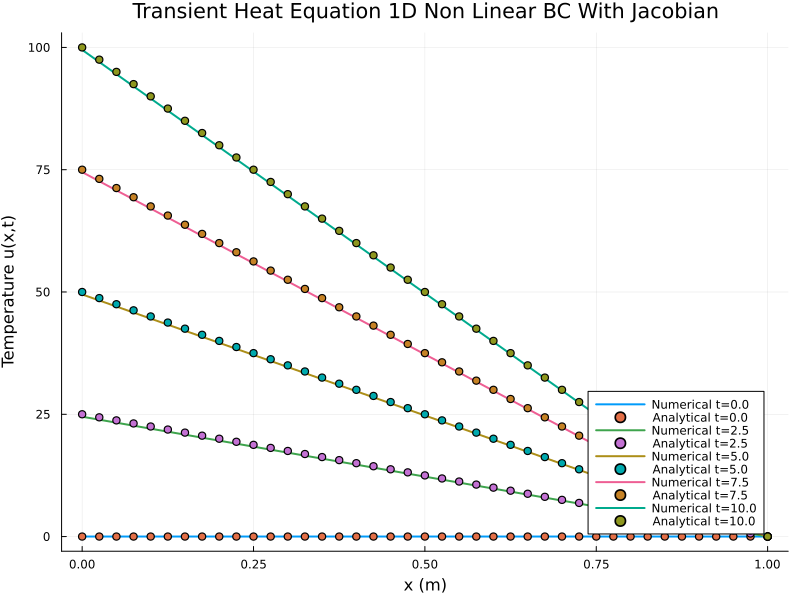

In [50]:
# --- 10. Visualisation ---

node_coords = [x.x[1] for x in getnodes(grid)]
analytical_solution_nl(x, t) = 10 * t * (1.0 - x)

plt_nl_jac = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Transient Heat Equation 1D Non Linear BC With Jacobian", 
           legend=:bottomright, size=(800,600))


# Choisir 5 indices répartis uniformément dans le vecteur de temps
n_times = 5
indices = round.(Int, range(1, length(sol_nl_jac.t), length=n_times))

for i in indices
    t_val = sol_nl_jac.t[i]
    u_num_nl_jac = sol_nl_jac.u[i]
    plot!(plt_nl_jac, node_coords, u_num_nl_jac, label="Numerical t=$(round(t_val, digits=2))", lw=2)
    scatter!(plt_nl_jac, node_coords, analytical_solution_nl.(node_coords, t_val), label="Analytical t=$(round(t_val, digits=2))", lw=2, ls=:dash)
end

display(plt_nl_jac)

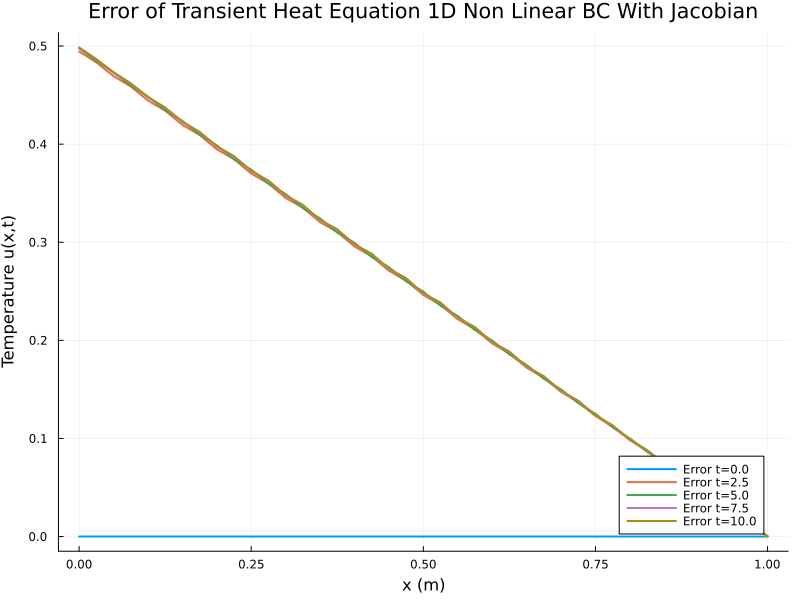

In [51]:
plt_error_nl_jac = plot(xlabel="x (m)", ylabel="Temperature u(x,t)", 
           title="Error of Transient Heat Equation 1D Non Linear BC With Jacobian", 
           legend=:bottomright, size=(800,600))

for i in indices
    t_val = sol_nl_jac.t[i]
    u_num_nl_jac = sol_nl_jac.u[i]
    plot!(plt_error_nl_jac, node_coords, abs.(u_num_nl_jac .- analytical_solution_nl.(node_coords, t_val)), label="Error t=$(round(t_val, digits=2))", lw=2)
end

display(plt_error_nl_jac)

## Section 4: 2D Poisson Equation Non Linear BC With Jacobian

### Section 4.1: Model Formulation 

We aim to numerically solve the two-dimensional stationary Poisson equation using the Finite Element Method. This problem is designed to test the implementation of non-linear boundary conditions and 2D spatial discretization.

The governing equation on a square domain $\\Omega = [0,1] \\times [0,1]$ is:
$$-\nabla^2 u = f(x,y)$$
Where:

  * $u(x,y)$ is the unknown scalar field.
  * $f(x,y)=0$ is the source term.

**Boundary Conditions (BCs)**

We impose the following Dirichlet boundary conditions:

  * **Left Boundary ($x=0$): Non-Linear Dirichlet Condition**
    $$u(0,y)^2 = 100$$
    This condition introduces a **non-linearity** because the unknown field $u$ is squared. For a physically meaningful solution, we typically select one root, e.g., $u(0,y) = 10$ (assuming the positive root).
  * **Right Boundary ($x=1$): Homogeneous Dirichlet Condition**
    $$u(1,y) = 0$$
  * **Bottom Boundary ($y=0$): Polynomial Dirichlet Condition**
    $$u(x,0) = 10(1-x)$$
  * **Top Boundary ($y=1$): Polynomial Dirichlet Condition**
    $$u(x,1) = 10(1-x)$$


### Section 4.2 Spatial Discretization

In [ ]:
# --- 1. Définition du maillage et des fonctions de forme ---

nels = (40, 40) # 40 éléments dans chaque direction (x et y)
domain_min = Vec((0., 0.)) # Coin inférieur gauche du domaine
domain_max = Vec((1., 1.)) # Coin supérieur droit du domaine

grid = generate_grid(Quadrilateral, nels, domain_min, domain_max)

ip = Lagrange{RefQuadrilateral, 1}()
qr = QuadratureRule{RefQuadrilateral}(2)
cellvalues = CellValues(qr, ip) 

fqr = FacetQuadratureRule{RefQuadrilateral}(2)
fvu = FacetValues(fqr, ip)

dh = DofHandler(grid)
add!(dh, :u, ip) # Ajout du champ scalaire 'u' avec l'interpolation définie
close!(dh)

# --- 2. Allocation des matrices prototypes ---

K_prototype = allocate_matrix(dh)

# --- 3. Conditions aux limites ---

ch = ConstraintHandler(dh)

left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")
bottom_boundary = getfacetset(grid, "bottom") # New line for bottom boundary
top_boundary = getfacetset(grid, "top")     # New line for top boundary

dbc_right = Dirichlet(:u, right_boundary, (x, t) -> 0.0)
add!(ch, dbc_right)

dbc_bottom = Dirichlet(:u, bottom_boundary, (x, t) -> 10.0 * (1.0 - x[1])) 
add!(ch, dbc_bottom) # New line for adding bottom boundary condition

dbc_top = Dirichlet(:u, top_boundary, (x, t) -> 10.0 * (1.0 - x[1]))
add!(ch, dbc_top) # New line for adding top boundary condition

close!(ch)

# --- 4. Local and Global Assembly ---

function assemble_element!(Ke, fe, cellvalues, cell_coords)
    n = getnbasefunctions(cellvalues)
    fill!(Ke, 0.0)
    fill!(fe, 0.0) # fe will remain zero if f_val is zero
    for q in 1:getnquadpoints(cellvalues)
        dΩ = getdetJdV(cellvalues, q)
        f_val = 0.0 # Source term f(x,y) is 0 for this analytical solution

        for i in 1:n, j in 1:n
            # ∇ϕ is now a Vec representing (dϕ/dx, dϕ/dy)
            ∇ϕ_i = shape_gradient(cellvalues, q, i)
            ∇ϕ_j = shape_gradient(cellvalues, q, j)
            # The dot product ∇ϕ_i ⋅ ∇ϕ_j is used for the Laplacian in 2D
            Ke[i, j] += (∇ϕ_i ⋅ ∇ϕ_j) * dΩ

            ϕ_i = shape_value(cellvalues, q, i)
            fe[i] += ϕ_i * f_val * dΩ # This term will be zero if f_val is zero
        end
    end
end

function assemble_global_Kf(cellvalues, K_proto, dh)
    Ke = zeros(getnbasefunctions(cellvalues), getnbasefunctions(cellvalues))
    fe = zeros(getnbasefunctions(cellvalues))
    f = zeros(ndofs(dh))
    K = copy(K_proto)
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        assemble_element!(Ke, fe, cellvalues, getcoordinates(cell))
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

In [ ]:
# --- 5. Fonctions pour la Condition aux Limites Non Linéaire ---

# Target value for the nonlinear BC: u(0,t)^2 = 100
Target = 100.0
res_functional(u_val, t) = u_val^2 - Target
dures_functional(u_val) = 2.0 * u_val

# Fonction pour assembler la contribution du résidu de la CL non linéaire
function assemble_nonlinear_bc_jacobian!(J_bc::SparseMatrixCSC, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    Je_bc = zeros(n_basefuncs_facet, n_basefuncs_facet)
    assembler = start_assemble(J_bc; fillzero=false)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet)
        facet_dofs = celldofs(facet) # New line: Get all DOFs of the facet (edge in 2D)

        fill!(Je_bc, 0.0)

        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(fvu, qp)
            u_qp = function_value(fvu, qp, u_current[facet_dofs]) # New line: Interpolate u_current at the quadrature point
            
            duval_qp = dures_functional(u_qp)

            for i in 1:n_basefuncs_facet
                ϕ_i = shape_value(fvu, qp, i)
                for j in 1:n_basefuncs_facet
                    ϕ_j = shape_value(fvu, qp, j)
                    Je_bc[i, j] -= duval_qp * ϕ_i * ϕ_j * dΓ
                end
            end
        end
        assemble!(assembler, facet_dofs, Je_bc) # New line: Use all DOFs of the facet for assembly
    end
end

In [ ]:
# --- 6. Problem Definition and Solver Setup for Stationary Non-Linear Problem ---

# Structure to pass parameters to the residual and Jacobian functions
struct ProblemPoisson
    K_prototype::SparseMatrixCSC{Float64, Int} # Prototype for the linear stiffness matrix
    dh::DofHandler
    cellvalues::CellValues
    ch::ConstraintHandler # Contains linear Dirichlet BCs
    fvu::FacetValues # For facet calculations (used in nonlinear BC)
    left_boundary_set # For iterating over the left boundary facets
end

# Function to compute the total residual R(u) for the stationary problem
function compute_total_residual!(R_total::Vector, u_current::Vector, p::ProblemPoisson)
    @unpack K_prototype, dh, cellvalues, ch, fvu, left_boundary_set = p

    K_linear, f_linear = assemble_global_Kf(cellvalues, K_prototype, dh)

    mul!(R_total, K_linear, u_current) # R_total = K_linear * u_current
    R_total .-= f_linear # R_total = K_linear * u_current - f_linear

    assemble_nonlinear_bc_residual!(R_total, u_current, dh, fvu, left_boundary_set)

    apply!(R_total, ch) # Apply linear BCs to the residual vector

    return R_total
end

# Function to compute the total Jacobian J(u) for the stationary problem
function compute_total_jacobian!(J_total::SparseMatrixCSC, u_current::Vector, p::ProblemPoisson)
    @unpack K_prototype, dh, cellvalues, ch, fvu, left_boundary_set = p

    K_linear, _ = assemble_global_Kf(cellvalues, K_prototype, dh)
    copy!(J_total, K_linear) # J_total = K_linear

    assemble_nonlinear_bc_jacobian!(J_total, u_current, dh, fvu, left_boundary_set, 0.0) # Pass 0.0 for time

    apply!(J_total, ch)

    return J_total
end


# --- 7. Setup for Newton's Method (Manual Implementation) ---

function newton_solve(
    u0::Vector{Float64},
    p::ProblemPoisson;
    max_iterations::Int = 100,
    tolerance::Float64 = 1e-6
)
    u_current = copy(u0) # Start with the initial guess

    # Pre-allocate buffers for residual and Jacobian to avoid repeated allocations
    # Type parameter `Float64` is used because `u_current` is `Float64`
    R_buffer = zeros(length(u_current))
    J_buffer = allocate_matrix(p.dh) # Use allocate_matrix for the Jacobian's sparsity pattern

    println("Starting Newton's method...")
    println("-------------------------------------")

    for iter = 1:max_iterations
        # 1. Compute Residual R(u_current)
        compute_total_residual!(R_buffer, u_current, p)
        residual_norm = norm(R_buffer)

        println("Iteration $(iter): Residual Norm = $(@sprintf("%.3e", residual_norm))")

        # 2. Check for convergence
        if residual_norm < tolerance
            println("-------------------------------------")
            println("Newton's method converged in $(iter-1) iterations.")
            return u_current # Return the converged solution
        end

        # 3. Compute Jacobian J(u_current)
        compute_total_jacobian!(J_buffer, u_current, p)

        # 4. Solve the linear system: J * delta_u = -R
        # Apply BCs to the right-hand side (-R_buffer) as well if `apply!` modifies it
        # Note: LinearAlgebra.\ (backslash operator) is efficient for sparse systems.
        delta_u = J_buffer \ (-R_buffer)

        # 5. Update the solution
        u_current .+= delta_u
    end

    println("-------------------------------------")
    println("Newton's method did NOT converge within $(max_iterations) iterations.")
    return u_current # Return the last computed solution
end


In [ ]:
plt = plot_scalar(
    dh,
    u_solution_manual, # The converged solution vector from your Newton solver
    title="2D Poisson Equation: Solution u(x,y)",
    xlabel="x (m)",
    ylabel="y (m)",
    colorbar_title="Solution value (u)",
    # You can specify other plotting attributes like `cbar=true` for colorbar
    # `size=(800, 600)` for plot dimensions
    size=(800, 600),
    c=:viridis, # Choose a colormap (e.g., :viridis, :jet, :grays)
    aspect_ratio=:equal, # Keeps aspect ratio correct for square/rectangular domains
    show_axis=true,
    axis_label=nothing # Prevent default labels if you want custom ones via xlabel/ylabel
)

# You can also add contours for specific values if desired
# plot_scalar!(plt, dh, u_solution_manual, levels=10, linecolor=:black, linewidth=0.5, legend=false)


display(plt)

Documentation on the solver : https://discourse.julialang.org/t/differences-between-nlsolve-and-optim-in-solving-system-of-equations/60467/13 
https://julianlsolvers.github.io/NLSolvers.jl/stable/#nonlineareq/ 
https://github.com/SciML/NonlinearSolve.jl

### Section 4.3 Validation of results

**Corner Compatibility Check**

It's crucial that the boundary conditions are consistent at the corners of the domain to ensure a well-behaved solution (especially for polynomial analytical solutions). Let's verify:

  * **Corner (0,0):**
      * From Left BC: $u(0,0) = 10$.
      * From Bottom BC: $u(0,0) = 10(1-0) = 10$. **(Compatible)**
  * **Corner (1,0):**
      * From Right BC: $u(1,0) = 0$.
      * From Bottom BC: $u(1,0) = 10(1-1) = 0$. **(Compatible)**
  * **Corner (0,1):**
      * From Left BC: $u(0,1) = 10$.
      * From Top BC: $u(0,1) = 10(1-0) = 10$. **(Compatible)**
  * **Corner (1,1):**
      * From Right BC: $u(1,1) = 0$.
      * From Top BC: $u(1,1) = 10(1-1) = 0$. **(Compatible)**

All boundary conditions are consistent at the corners.

**Analytical Solution and Source Term**

We can derive a simple analytical solution $u(x,y)$ that satisfies all these boundary conditions, and then find the corresponding source term $f(x,y)$.

The solution:
$$u(x,y) = 10(1-x)$$

Let's verify this solution against the BCs:

  * $u(0,y) = 10(1-0) = 10$. (Matches Left BC after choosing positive root of $u^2=100$)
  * $u(1,y) = 10(1-1) = 0$. (Matches Right BC)
  * $u(x,0) = 10(1-x)$. (Matches Bottom BC)
  * $u(x,1) = 10(1-x)$. (Matches Top BC)

All boundary conditions are satisfied by this analytical solution.

**Source Term $f(x,y)$**

Now, we calculate the Laplacian of our analytical solution to find the corresponding source term $f(x,y) = -\\nabla^2 u = -\\left(\\frac{\\partial^2 u}{\\partial x^2} + \\frac{\\partial^2 u}{\\partial y^2}\\right)$.

1.  **Second derivative with respect to $x$:**
    $$\frac{\partial u}{\partial x} = \frac{\partial}{\partial x} (10 - 10x) = -10$$   $$\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x} (-10) = 0$$
2.  **Second derivative with respect to $y$:**
    $$\frac{\partial u}{\partial y} = \frac{\partial}{\partial y} (10(1-x)) = 0 \quad \text{(since } 10(1-x) \text{ does not depend on } y)$$   $$\frac{\partial^2 u}{\partial y^2} = \frac{\partial}{\partial y} (0) = 0$$

Therefore, the source term is:
$$f(x,y) = -(0 + 0) = 0$$

## Section 5: 2D Heat Equation Non Linear BC With Jacobian

### Section 5.1: Model Formulation 

We're solving the 2D transient heat equation, which describes how temperature $u(x,y,t)$ changes over time and space.
$$\frac{\partial u}{\partial t} = D\nabla^2 u + f(x,y,t)$$
where $D=1$ is the **thermal diffusivity** of the material, and $\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$ is the 2D Laplacian operator.

* Source Term: To extend your 1D source, we'll keep its $x$-dependence:
    $$f(x,y,t) = 10(1-x)$$

The simulation takes place on a **square domain** (a unit square $[0,1] \times [0,1]$).

At the start of the simulation ($t=0$), the temperature is uniformly zero throughout the entire domain:
$$u(x,y,0) = 0 \quad \text{for all } (x,y) \text{ in the domain}$$

**Boundary Conditions (BCs)**

Temperature conditions are applied to all four sides of the square domain:

* **Right Boundary ($x=1$), Top Boundary ($y=1$), and Bottom Boundary ($y=0$):**
    The temperature is fixed at zero on these three boundaries:
    $$u(1,y,t) = 0 \quad \text{on } \partial\Omega_{\text{right}}$$
    $$u(x,1,t) = 0 \quad \text{on } \partial\Omega_{\text{top}}$$
    $$u(x,0,t) = 0 \quad \text{on } \partial\Omega_{\text{bottom}}$$

* **Left Boundary ($x=0$, Nonlinear and Time-Dependent):**
    The temperature on the left boundary follows a nonlinear and time-dependent relationship. This condition ensures consistency with the initial condition at $t=0$ and a smooth temperature ramp-up.
    $$u(0,y,t)^2 = 100t^2$$


### Section 5.2 Spatial Discretization

In [31]:
# --- 1. Mesh and shape function definition ---

# For 2D, we need a 2-element tuple for the number of elements
nels = (40, 40) 
left_bottom_corner = Vec((0.0, 0.0))
right_top_corner = Vec((1.0, 1.0))
grid = generate_grid(Quadrilateral, nels, left_bottom_corner, right_top_corner)

# Use Lagrange elements for a 2D reference quadrilateral
ip = Lagrange{RefQuadrilateral, 1}()
qr = QuadratureRule{RefQuadrilateral}(2)
cellvalues = CellValues(qr, ip)

# Facet quadrature rule for 2D reference quadrilateral (e.g., for boundaries)
fqr = FacetQuadratureRule{RefQuadrilateral}(2)
fvu = FacetValues(fqr, ip)

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh)

# --- 2. Allocation of prototype matrices ---

# K_prototype and M_prototype are now for 2D problem size
K_prototype = allocate_matrix(dh)
M_prototype = allocate_matrix(dh)

# --- 3. Boundary Conditions ---

ch = ConstraintHandler(dh)

# Define all 4 boundaries for 2D
left_boundary = getfacetset(grid, "left")
right_boundary = getfacetset(grid, "right")
top_boundary = getfacetset(grid, "top")
bottom_boundary = getfacetset(grid, "bottom")

# Right, Top, and Bottom Boundaries fixed at zero
dbc_right = Dirichlet(:u, right_boundary, (x, t) -> 0.0)
dbc_top = Dirichlet(:u, top_boundary, (x, t) -> 0.0)
dbc_bottom = Dirichlet(:u, bottom_boundary, (x, t) -> 0.0)

# Add all boundary conditions to the constraint handler
add!(ch, dbc_right)
add!(ch, dbc_top)
add!(ch, dbc_bottom)
close!(ch)

# --- 4. Local and global assembly ---

# Note: The assemble_element! function needs to handle 2D gradients (∇ϕ_i, ∇ϕ_j are Vecs)
# And spatial_coordinate will return a Vec with x and y components.
function assemble_element!(Ke, fe, cellvalues, cell_coords, t)
    n = getnbasefunctions(cellvalues)
    fill!(Ke, 0.0)
    fill!(fe, 0.0)
    for q in 1:getnquadpoints(cellvalues)
        dΩ = getdetJdV(cellvalues, q)
        # spatial_coordinate now returns a Vec((x, y))
        x_coord, y_coord = spatial_coordinate(cellvalues, q, cell_coords)
        
        # Source term f(x,y,t) = 10(1-x)
        f_val = 10.0 * (1.0 - x_coord) *  (min(t, t_rise))
        
        for i in 1:n, j in 1:n
            # shape_gradient now returns a Vec((∇ϕ_x, ∇ϕ_y))
            ∇ϕ_i = shape_gradient(cellvalues, q, i)
            ∇ϕ_j = shape_gradient(cellvalues, q, j)
            # Dot product for 2D gradients: ∇ϕ_i ⋅ ∇ϕ_j
            Ke[i, j] += (∇ϕ_i ⋅ ∇ϕ_j) * dΩ
        end
        for i in 1:n
            ϕ_i = shape_value(cellvalues, q, i)
            fe[i] += ϕ_i * f_val * dΩ
        end
    end
end

# assemble_global_Kf function remains largely the same, as it iterates over cells
# and uses the local assembly function.
function assemble_global_Kf(cellvalues, K_proto, dh, t)
    Ke = zeros(getnbasefunctions(cellvalues), getnbasefunctions(cellvalues))
    fe = zeros(getnbasefunctions(cellvalues))
    f = zeros(ndofs(dh))
    K = copy(K_proto) # Start with prototype
    
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        assemble_element!(Ke, fe, cellvalues, getcoordinates(cell), t)
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

# assemble_M! function remains largely the same, as it iterates over cells
# and calculates the mass matrix.
function assemble_M!(M_proto, cellvalues, dh)
    n = getnbasefunctions(cellvalues)
    Me = zeros(n, n)
    assembler = start_assemble(M_proto)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues, cell)
        fill!(Me, 0.0)
        for q in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q)
            for i in 1:n, j in 1:n
                ϕ_i = shape_value(cellvalues, q, i)
                ϕ_j = shape_value(cellvalues, q, j)
                Me[i, j] += ϕ_i * ϕ_j * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), Me)
    end
    return M_proto
end

assemble_M! (generic function with 1 method)

In [39]:
# --- 5. Fonctions pour la Condition aux Limites Non Linéaire ---

# Target value for the nonlinear BC: u(0,y,t)^2 = 100t^2
t_rise = 1
TargetValue(t) = 100.0 * (min(t, t_rise))^4
res_functional(u_val, t) = u_val^2 - TargetValue(t)
dures_functional(u_val) = 2.0 * u_val

# Fonction pour assembler la contribution du résidu de la CL non linéaire
function assemble_nonlinear_bc_residual!(R_bc::Vector, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    re_bc = zeros(n_basefuncs_facet) # Résidu local pour la CL (taille des DOFs de la facette)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet) # Réinitialise fvu pour la facette actuelle
    
        facet_dofs = celldofs(facet)
        u_facet_nodes_vals = u_current[facet_dofs]

        fill!(re_bc, 0.0) # Réinitialise le résidu local pour cette facette

        # Loop over quadrature points on the facet (edge)
        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(fvu, qp) # Élément de surface pondéré (longueur sur l'arête en 2D)
            
            u_qp = function_value(fvu, qp, u_facet_nodes_vals) 
            val_qp = res_functional(u_qp, t)

            for i in 1:n_basefuncs_facet
                ϕ_i = shape_value(fvu, qp, i) # Basis function for the current facet DOF
                re_bc[i] -= val_qp * ϕ_i * dΓ
            end
        end
        assemble!(R_bc, celldofs(facet), re_bc)
    end
end

assemble_nonlinear_bc_residual! (generic function with 1 method)

### Section 5.3 Time integration

In [43]:
function assemble_nonlinear_bc_jacobian!(J_bc::SparseMatrixCSC, u_current::Vector, dh::DofHandler, fvu::FacetValues, boundary_set, t::Float64)
    n_basefuncs_facet = getnbasefunctions(fvu)
    Je_bc = zeros(n_basefuncs_facet, n_basefuncs_facet) # Jacobien local pour la CL
    assembler = start_assemble(J_bc; fillzero=false)

    for facet in FacetIterator(dh, boundary_set)
        Ferrite.reinit!(fvu, facet)
        
        # Get the global DOFs associated with this facet (edge nodes)
        facet_dofs = celldofs(facet)
        
        # Get the current solution values at these facet DOFs
        u_facet_nodes_vals = u_current[facet_dofs]

        fill!(Je_bc, 0.0)

        for qp in 1:getnquadpoints(fvu)
            dΓ = getdetJdV(fvu, qp)
            
            # Interpolate the solution `u_current` to the current quadrature point on the facet
            # This is `u(x_q, y_q, t)` on the boundary
            u_qp = function_value(fvu, qp, u_facet_nodes_vals) 
            
            # Analytical derivative of the BC residual with respect to u
            duval_qp = dures_functional(u_qp) 

            for i in 1:n_basefuncs_facet # Test functions
                ϕ_i = shape_value(fvu, qp, i)
                for j in 1:n_basefuncs_facet # Trial functions
                    ϕ_j = shape_value(fvu, qp, j)
                    Je_bc[i, j] -= duval_qp * ϕ_i * ϕ_j * dΓ
                end
            end
        end
        # Assemble the local BC Jacobian into the global J_bc
        # Use `celldofs(facet)` as this gives the global DOFs for the current facet's nodes.
        assemble!(assembler, celldofs(facet), Je_bc) 
    end
end

assemble_nonlinear_bc_jacobian! (generic function with 1 method)

In [44]:
# --- 6. Definition of the ODE equation ---

# Structure to pass parameters to the ODE
struct ProblemParameters_2D
    K_prototype::SparseMatrixCSC{Float64, Int}
    M_prototype::SparseMatrixCSC{Float64, Int} 
    dh::DofHandler
    cellvalues::CellValues
    ch::ConstraintHandler # Contains only linear BCs
    fvu::FacetValues # For facet BCs
    left_boundary_set # For looping over the left boundary
    K_buffer::SparseMatrixCSC{Float64, Int} # Buffer for global stiffness matrix
    f_buffer::Vector{Float64} # Buffer for global force vector
end

function heat_equation_ode!(R_total, u_current, p::ProblemParameters_2D, t)
    @unpack K_prototype, M_prototype, dh, cellvalues, ch, fvu, left_boundary_set, K_buffer, f_buffer = p

    update!(ch, t)
    apply!(K_buffer, f_buffer, ch)
    R_total .= f_buffer
    
    mul!(R_total, K_buffer, u_current, -1.0, 1.0) # R_total = -1.0 * K_buffer * u_current + 1.0 * R_total

    assemble_nonlinear_bc_residual!(R_total, u_current, dh, fvu, left_boundary_set, t)

    return nothing
end


# --- 7. ANALYTIC Jacobian Function ---

function heat_jac!(J, u_current, p::ProblemParameters_2D, t)
    @unpack K_prototype, M_prototype, dh, cellvalues, ch, fvu, left_boundary_set, K_buffer, f_buffer = p

    nonzeros(J) .= nonzeros(K_prototype)
    mul!(J, J, -1.0) # J now represents -K_internal (from diffusion)

    assemble_nonlinear_bc_jacobian!(J, u_current, dh, fvu, left_boundary_set, t)

    update!(ch, t)
    
    apply!(J, ch)

    return J # The Jacobian function must return the modified Jacobian matrix
end


# --- 8. Initial Condition ---
u0 = zeros(ndofs(dh))


# --- 9. Simulation Time Interval ---

# You can adjust tspan as needed. Let's use a smaller interval for quick testing.
tspan = (0.0, 10.0) # Simulation time from t=0.0 to t=1.0


# --- 10. Problem Definition and Solving ---

initial_K_buffer, initial_f_buffer = assemble_global_Kf(cellvalues, K_prototype, dh, 0.0)

# Create the parameters struct for the ODE problem
params = ProblemParameters_2D(K_prototype, M_prototype, dh, cellvalues, ch, fvu, left_boundary, initial_K_buffer, initial_f_buffer)

# Define the ODE function, specifying the mass matrix and Jacobian
rhs_ode_2D = ODEFunction(heat_equation_ode!,
                      mass_matrix = M_prototype,
                      jac = heat_jac!,
                      jac_prototype = K_prototype) # Use K_prototype for the sparse structure of J

# Create the ODE problem
prob_2D = ODEProblem(rhs_ode_2D, u0, tspan, params)

# Solve the ODE problem using an implicit solver (Rodas5 is a good choice for stiff problems)
sol_nl_jac_2D = DifferentialEquations.solve(prob_2D, Rodas5(autodiff=false),
                  reltol = 1e-3, abstol = 1e-3, saveat=0.1);

println("2D Heat Equation with Nonlinear BC solved successfully!")

┌ Warning: Rosenbrock methods on equations without differential states do not bound the error on interpolations.
└ @ OrdinaryDiffEqCore C:\Users\anouc\.julia\packages\OrdinaryDiffEqCore\zs1s7\src\solve.jl:106


2D Heat Equation with Nonlinear BC solved successfully!


### Section 5.4 Validation of results

Starting 2D Visualization with mypostprocess...
Generating GIF with cell-averaged heatmaps...
GIF saved to transient_solution_2D_cell_averaged.gif


[ Info: Saved animation to C:\Users\anouc\Desktop\HydrogenProject\transient_solution_2D_cell_averaged.gif


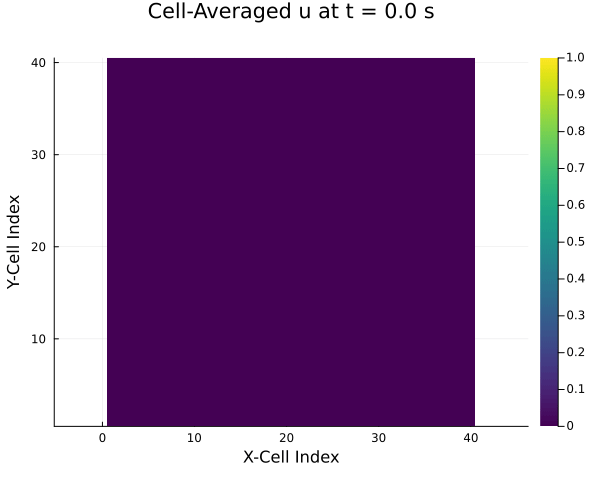

In [45]:
# --- 10. Visualization (using mypostprocess and Plots.heatmap) ---

# Function to post-process nodal solution to cell-averaged values
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cellvalues::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells) # Will contain cell-averaged values

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cellvalues, cell)
        
        dof_range_u = dof_range(dh, :u)
        uloc = u_nodal_solution[celldofs(dh, cell_num)[dof_range_u]] # Nodal solutions for the current cell
        
        cell_integral_u = 0.0      # Integral of u over the cell
        cell_physical_area = 0.0   # Physical area of the cell
        
        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point) # Differential volume element
            cell_u_at_qpoint = function_value(cellvalues, q_point, uloc) # Value of u at the quadrature point
            
            cell_physical_area += dΩ      # Accumulate cell area
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumulate integral of u
        end

        # Calculate the average of u over the cell and assign it
        myu[cell_num] = cell_integral_u / cell_physical_area
    end  

    myu2d = reshape(myu, nels[1], nels[2])
    
    return myu2d # Return the 2D matrix of cell averages
end

println("Starting 2D Visualization with mypostprocess...")

# Determine the global min/max temperature for a consistent color scale across all plots/frames
all_temperatures = vcat(sol_nl_jac_2D.u...) # Concatenate all solution vectors
min_temp = minimum(all_temperatures)
max_temp = maximum(all_temperatures)

# Ensure min_temp and max_temp are not equal if all values are the same (e.g., all zeros initially)
if min_temp == max_temp
    min_temp -= 1.0 # Give it some range if it's flat
    max_temp += 1.0
end

println("Generating GIF with cell-averaged heatmaps...")
anim_postprocess = @animate for i in 1:length(sol_nl_jac_2D.t)
    t_current = sol_nl_jac_2D.t[i]
    u_current = sol_nl_jac_2D.u[i]
    
    # Use your post-processing function
    myu2d_at_t = mypostprocess(u_current, dh, cellvalues, nels)

    title_str = "Cell-Averaged u at t = $(round(t_current, digits=2)) s"

    p_heatmap = Plots.heatmap(myu2d_at_t,
                              title=title_str,
                              aspect_ratio=:equal, # Maintain domain aspect ratio
                              c=:viridis, # Color map
                              colorrange=(min_temp, max_temp), # Consistent color scale
                              xlabel="X-Cell Index", # Label for the horizontal axis (columns)
                              ylabel="Y-Cell Index", # Label for the vertical axis (rows)
                              )
    
    Plots.plot(p_heatmap, size=(600, 500)) # Plot just the heatmap
end
Plots.gif(anim_postprocess, "transient_solution_2D_cell_averaged.gif", fps=10)
println("GIF saved to transient_solution_2D_cell_averaged.gif")

try
    # Attempt to display the last generated GIF inline
    display("image/gif", read("transient_solution_2D_cell_averaged.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_2D_cell_averaged.gif' manually to view.")
end

---
---
---
---
---
---

## Section 3: 2D Heat Equation Non Linear BC

### Section 2.1 Problem Formulation

**Governing Equation (Partial Differential Equation - PDE)**

We are solving the 2D transient heat equation, which describes the evolution of temperature $u(x,y,t)$ over time and space.
    $$\frac{\partial u}{\partial t} = D\nabla^2 u$$
    where $\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$ is the Laplacian operator.

* Source Term: There is **no source term** ($f(x,y,t) = 0$) in the domain. All heat transfer originates from the boundary conditions.
* Thermal diffusivity of the material : $D=1$


**Initial Condition (IC)**

At the beginning of the simulation ($t=0$), the temperature is uniformly zero across the entire domain.
    $$u(x,y,0) = 0 \quad \text{for all } (x,y) \text{ in the domain}$$


**Boundary Conditions (BCs)**

Temperature conditions are imposed on all four sides of the rectangular domain:

* *Right, Top, and Bottom Boundaries:*
    The temperature is fixed at zero on these three boundaries.
    $$u(x,y,t) = 0 \quad \text{on } \partial\Omega_{\text{right}}, \partial\Omega_{\text{top}}, \partial\Omega_{\text{bottom}}$$

* *Left Boundary (Nonlinear and Time-Dependent):*
    The temperature on the left boundary (`left_patch`) follows a nonlinear and time-dependent relationship. This condition ensures that the temperature starts at zero at $t=0$ (to be consistent with the initial condition) and ramps up.

    * *Condition:*
        $$u(x,y,t)^2 = \text{TargetValue}(t) \quad \text{on } \partial\Omega_{\text{left}}$$

    * *Target Value Function:**The `TargetValue(t)` is defined as:*
        $$\text{TargetValue}(t) = 100 \times \begin{cases} t & \text{if } t \le t_{rise} \\ t_{rise} & \text{if } t > t_{rise} \end{cases}$$
        Here, $t_{rise}$ is a specified time constant (e.g., $t_{rise} = 1$ second). This means the target value for $u^2$ ramps linearly from $0$ at $t=0$ up to $100 \times t_{rise}$ at $t=t_{rise}$, and then remains constant at $100 \times t_{rise}$ for all subsequent times.

    * *Implication for $u$:* This means $u(x,y,t) = \sqrt{\text{TargetValue}(t)}$.
        * At $t=0$: $u(x,y,0) = \sqrt{0} = 0$. This ensures consistency with the initial condition.
        * At $t=t_{rise}$: $u(x,y,t_{rise}) = \sqrt{100 \times t_{rise}}$.
        * For $t > t_{rise}$: $u(x,y,t) = \sqrt{100 \times t_{rise}}$.

    * *Residual Formulation for Solver:* For a nonlinear solver (like Newton-Raphson), this boundary condition is typically formulated as a residual that must be driven to zero:
        $$\text{Residual}(u,t) = u^2 - \text{TargetValue}(t)$$


### Section 2.2 Mesh, Domain Setup and Global Matrix Assembly

In our case, the semi-discrete system (after spatial discretization) of the transient heat equation $\frac{\partial u}{\partial t} = D\nabla^2 u$ can be written as:
$$M \dot{u} + K u - f_{BC}(u, t) = 0$$
where:
* $M$ is the global **mass matrix**.
* $K$ is the global **stiffness matrix** (representing the diffusion term).
* $\dot{u} = \frac{du}{dt}$ is the time derivative of the temperature vector.
* $f_{BC}(u, t)$ is the load vector resulting from the boundary conditions, which crucially includes the *nonlinear and time-dependent* contribution from the left boundary.

In [ ]:
struct FEMParams 
    K::SparseMatrixCSC{Float64, Int64}
    ch::ConstraintHandler
    dh::DofHandler
    cvu::CellValues
    fvu::FacetValues
    left_dof_indices::Vector{Int}
    u_global_buffer::Vector{Float64} # Buffer pour u avec contraintes appliquées
end

In [ ]:
nels = (3,2)
grid = generate_grid(Quadrilateral, nels);

# Vérifier l'ordre des numerotation des noeuds, de gauche à droite puis de bas en hat.
# for i in 1:length(grid.nodes)
#     println("Node $(i): $(grid.nodes[i].x)")
# end

ip  = Lagrange{RefQuadrilateral, 1}()
qr  = QuadratureRule{RefQuadrilateral}(2)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ip);
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvu      = FacetValues(qr_facet, ip, ipg) # required for inlet integral constraint 

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh);
M = allocate_matrix(dh);

f = zeros(ndofs(dh));

ch = ConstraintHandler(dh);

left_patch = getfacetset(dh.grid, "left")
∂Ω₂ = union(getfacetset.((grid,), ["top", "bottom", "right"])...)
dbc2 = Dirichlet(:u, ∂Ω₂, (x, t) -> 0)
add!(ch, dbc2)
close!(ch);

In [ ]:
function assemble_K!(K::SparseMatrixCSC, f::Vector, cellvalues::CellValues, dh::DofHandler)

        n_basefuncs = getnbasefunctions(cellvalues)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)

        assembler = start_assemble(K, f)

        for cell in CellIterator(dh)

            fill!(Ke, 0)
            fill!(fe, 0)

            Ferrite.reinit!(cellvalues, cell)

            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    ∇v = shape_gradient(cellvalues, q_point, i)
                    fe[i] += 0. * v * dΩ
                    for j in 1:n_basefuncs
                        ∇u = shape_gradient(cellvalues, q_point, j)
                        Ke[i, j] += 1e-1*(∇v ⋅ ∇u) * dΩ
                    end
                end
            end

            assemble!(assembler, celldofs(cell), Ke, fe)
        end
        return K, f
end

#println(assemble_K!(K, f, cvu, dh))


function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end

#println(assemble_M!(K, cvu, dh))

### Section 2.3 Residual and Jacobian Formulations

**Residual and Jacobian for the Nonlinear System**

For the implicit time integration (e.g., using a solver like `Rodas5`), we need to define the residual function $R(u, \dot{u}, t)$ and its Jacobian. The solver typically seeks to find $u$ such that $R(u, \dot{u}, t) = 0$.

$$R(\mathbf{u}, \dot{\mathbf{u}}, t) = \mathbf{M} \dot{\mathbf{u}}(t) + \mathbf{K} \mathbf{u}(t) - \mathbf{f}_{BC}(\mathbf{u}(t), t) = 0$$

We will define two main sets of functions:

1.  **`heat_rhs_element!` and `heat_rhs`**: These functions will compute the global residual vector $R(u, \dot{u}, t)$. The nonlinear boundary condition on the left boundary will be incorporated into `heat_rhs_element!` when iterating over the facets of `left_patch`.
2.  **`heat_jac_element!` and `heat_jac`**: These functions will compute the Jacobian of the residual with respect to $u$, which is $\frac{\partial R}{\partial u}$. This Jacobian is essential for the Newton-Raphson iterations performed by the implicit solver. The derivative of the nonlinear boundary condition (e.g., $2u$ from $u^2$) will be a key part of this Jacobian.

In [ ]:
const trise = 1.0

function TargetValue(t)
    if t <= trise
        return 100.0 * t
    else
        return 100.0 * trise
    end
end

# This is the residual of the nonlinear BC itself: u^2 - TargetValue(t)
res_functional(u_val, t) = u_val^2 - TargetValue(t)


In [ ]:
# --- Contribution élémentaire de la condition limite ---
function heat_rhs_element!(res_bc_element::Vector{Float64}, ue::Vector{Float64}, fvu::FacetValues, t::Float64)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        u_qp = function_value(fvu, qp, ue)
        val_qp = res_functional(u_qp, t)

        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            res_bc_element[j] += val_qp * φⱼ * dΓ
        end
    end    
    return
end

# --- Fonction globale du côté droit (f_RHS) pour M * du/dt = f_RHS(u,t) ---
function heat_rhs!(res_global::Vector{Float64}, u_current::Vector{Float64}, p::FEMParams, t::Float64) # Utilisation de FEMParams
    
    p.u_global_buffer .= u_current
    update!(p.ch, t)
    apply!(p.u_global_buffer, p.ch)

    mul!(res_global, p.K, p.u_global_buffer, -1.0, 0.0)

    n_basefuncs_cell = ndofs_per_cell(p.dh)
    ue = zeros(n_basefuncs_cell)
    res_bc_element = zeros(n_basefuncs_cell)

    for facet in FacetIterator(p.dh, p.left_dof_indices)
        Ferrite.reinit!(p.fvu, facet)
        u_celldofs = celldofs(facet)
        ue .= @views p.u_global_buffer[u_celldofs]
        fill!(res_bc_element, 0.0)
        heat_rhs_element!(res_bc_element, ue, p.fvu, t)
        assemble!(res_global, u_celldofs, res_bc_element)
    end
    
    for dof_idx in p.ch.constrained_dofs
        res_global[dof_idx] = u_current[dof_idx]
    end

    current_target_value = TargetValue(t)
    for dof_idx in p.left_dof_indices
        res_global[dof_idx] = u_current[dof_idx]^2 - current_target_value
    end

    return nothing
end

In [ ]:
# dures_functional(u) = 2*u # Assumé défini

# --- Contribution Jacobienne élémentaire de la condition limite non linéaire ---
function heat_jac_element!(Je::Matrix{Float64}, ue::Vector{Float64}, fvu::FacetValues)
    n_basefuncs = getnbasefunctions(fvu)
    for qp in 1:getnquadpoints(fvu)
        dΓ = getdetJdV(fvu, qp)
        u_qp = function_value(fvu, qp, ue)
        duval_qp = dures_functional(u_qp)

        for j in 1:n_basefuncs
            φⱼ = shape_value(fvu, qp, j)
            for i in 1:n_basefuncs
                φᵢ = shape_value(fvu, qp, i)
                Je[j, i] += duval_qp * φᵢ * φⱼ * dΓ
            end
        end
    end    
    return
end

# --- Fonction globale du Jacobien (df_RHS/du) ---
function heat_jac!(J::SparseMatrixCSC{Float64, Int64}, u_current::Vector{Float64}, p::FEMParams, t::Float64)
    
    dropzeros!(J)

    mul!(J, p.K, -1.0, 0.0)

    for dof_idx in p.ch.constrained_dofs
        J[dof_idx, dof_idx] = 1.0
    end

    for dof_idx in p.left_dof_indices
        J[dof_idx, dof_idx] = 2.0 * u_current[dof_idx]
    end

    return nothing
end

### Section 2.4 Time Integration and Solution

Finally, this section ties everything together. We define the `TargetValue(t)` function, set up the `ODEProblem` using the residual and Jacobian functions, and then use `DifferentialEquations.jl` to solve the transient problem over time.

* **`TargetValue(t)` Definition**
* **`ODEProblem` Setup**: Integrating the initial condition and time span.
* **Solution with `Rodas5` Solver**

In [ ]:
# 0. All previous definitions (mesh, K_global, M_global, heat_rhs!, heat_jac!, FEMParams, TargetValue, res_functional, dures_functional etc.) are assumed defined.

# Set time constants
T = 2.0

# Initial conditions
u0 = zeros(dh.ndofs)

# Prototype for the Jacobian sparsity pattern
jac_prototype = sparse(K)
dropzeros!(jac_prototype)

# Create FEMParams struct for ODE functions
p = FEMParams(K, ch, dh, cell_fe_values, facet_fe_values, left_dof_indices, copy(u0))

# Define the ODE function for DifferentialEquations.jl
rhs = ODEFunction(heat_rhs!, mass_matrix = M_global; jac = heat_jac!, jac_prototype = jac_prototype)

# Create the ODE problem
problem = ODEProblem(rhs, u0, (0.0, T), p)

# Define the step limiter function for applying Ferrite constraints
function ferrite_limiter!(u_current_state, _, p_ode::FEMParams, t)
    update!(p_ode.ch, t)
    apply!(u_current_state, p_ode.ch) # Modifies u_current_state in place
    return nothing # Essential for step_limiter!
end

# Define the time stepper with the custom limiter
# Use Rodas5P as it allows step_limiter!
timestepper = Rodas5(autodiff = false, step_limiter! = ferrite_limiter!); # Rodas5P is deprecated, use Rodas5 directly with step_limiter!

# Initialize the integrator for manual control or customized solving
integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = 0.01,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = false, # Set to false for less verbose output
    d_discontinuities = [1.0] # To handle the discontinuity in TargetValue at t=1.0
);

# Solve the problem using the initialized integrator
sol = solve!(integrator)


# Function to post-process nodal solution to cell-averaged values
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cvu::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells)

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cvu, cell)
        
        uloc_indices = celldofs(cell)
        # Ensure only :u field DOFs are considered for uloc
        uloc = u_nodal_solution[uloc_indices[dof_range(dh, :u)]]
        
        cell_integral_u = 0.0
        cell_physical_area = 0.0
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            cell_u_at_qpoint = function_value(cvu, q_point, uloc)
            
            cell_physical_area += dΩ
            cell_integral_u += cell_u_at_qpoint * dΩ
        end

        myu[cell_num] = cell_integral_u / cell_physical_area
    end
    
    myu2d = reshape(myu, nels[1], nels[2])
    
    return myu2d
end

# Ensure nels is defined for the grid used
# Assuming grid was defined as `grid = generate_grid(Quadrilateral, (nx, ny));`
# You need to define nels based on your grid generation.
# For example, if your grid was `grid = generate_grid(Quadrilateral, (20, 20));`
nels = (grid.nx, grid.ny) # Assuming these fields exist or derive from grid generation

# GIF generation part
println("Generating GIF...")
anim = @animate for i in 1:length(sol.t)
    t_current = sol.t[i]
    u_current = sol.u[i]
    myu2d_at_t = mypostprocess(u_current, dh, cell_fe_values, nels)
    title_str = "Solution u at t = $(round(t_current, digits=2))"
    p1 = Plots.contour(myu2d_at_t', fill=true, title=title_str, aspect_ratio=:equal, c=:viridis)
    p2 = Plots.surface(myu2d_at_t', title=" ", aspect_ratio=:equal, c=:viridis)
    Plots.plot(p1, p2, layout=(1,2), size=(1000, 500))
end
Plots.gif(anim, "transient_solution_penalty.gif", fps=10)
println("GIF saved to transient_solution_penalty.gif")

try
    display("image/gif", read("transient_solution_penalty.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_penalty.gif' manually to view.")
end

---
---
---
---
---
---

## TEST SEPERATED DOFS

**Le rôle de `get_constrained_value` :**
    Cette fonction sert précisément à aller chercher la valeur prescrite pour un DOF contraint donné et à un instant `t` donné.

**Pourquoi on a besoin de ces valeurs fixées (`u_c`) :**
    Même si ces valeurs sont fixées, elles influencent les DOFs "libres" (ceux dont la température n'est pas fixée et que le solveur doit calculer). Dans l'équation complète du système (avant condensation) :
    $$M \frac{du}{dt} + K u = f_{source}$$
Si on sépare $u$ en $u_f$ (libres) et $u_c$ (contraints), et qu'on fait la condensation, on obtient une équation pour les DOFs libres :
    $$M_{ff} \frac{du_f}{dt} + K_{ff} u_f = f_{f\_source} - K_{fc} u_c - M_{fc} \frac{du_c}{dt}$$

Le terme $K_{fc} u_c$ (et potentiellement $M_{fc} \frac{du_c}{dt}$ si les CL dépendent du temps) est la contribution des DOFs contraints au côté droit de l'équation des DOFs libres. Pour calculer ce terme, on a besoin de connaître les valeurs de $u_c$. C'est là que `get_constrained_value` intervient : elle nous fournit ces $u_c$ à partir desquelles on calculera les valeurs actuelles de $u_f$.

eurs de $u_c$ sont des **entrées** pour ce calcul, pas des sorties. Le résidu est calculé *à partir* des  et des valeurs *connues* de $u_c$.

Une fois que nous avons condensé le système en utilisant les valeurs de $u_c$ (fournies par `get_constrained_value`), notre solveur ODE ne s'occupe plus que des DOFs libres (`u_f`).
    * Les DOFs internes sont par définition des DOFs libres.

En bref, `get_constrained_value` ne "calcule" pas la température des DOFs contraints ; elle **récupère la valeur prescrite** par la condition aux limites de Dirichlet, et cette valeur est ensuite utilisée pour influencer le calcul des DOFs libres.

In [ ]:
# Fonction pour obtenir la valeur d'une CL pour un DOF donné et un temps donné
function get_constrained_value(ch::ConstraintHandler, dof_idx::Int, t::Float64)
    for dbc in ch.dbcs  # dbcs est une liste de DirichletBoundaryCondition
        if dof_idx in dbc.dof_indices 
            dof_coords = Ferrite.getcoordinates(ch.dh.grid, dof_idx)  # Récupérer les coordonnées du DOF pour le passer à la val_func
            return dbc.val_func(dof_coords, t)
        end
    end
    return NaN
end

dof_test = 2
t_test = 0.5
val = get_constrained_value(ch, dof_test, t_test)
println("Valeur pour DOF $dof_test_4 à t=$t_test : Obtenu=$val")

function heat_rhs!(du_free, u_free, p::RHSparams, t)
    @unpack K_full, f_full_source, M_full, ch, dh, cvu, fvu, free_dofs, constrained_dofs = p

    # --------- 1. Reconstruire le vecteur de solution 'u_full' complet (DOFs libres + DOFs contraints)
    u_full = zeros(dh.ndofs)
    u_full[free_dofs] .= u_free # Les valeurs des DOFs libres proviennent du solveur

    # Remplir les valeurs des DOFs contraints (fixés à 0 pour dbc2)
    u_constrained_values = zeros(length(constrained_dofs))
    for (i, dof_idx) in enumerate(constrained_dofs)
        u_constrained_values[i] = get_constrained_value(ch, dof_idx, t)
    end
    u_full[constrained_dofs] .= u_constrained_values # Mettre à jour u_full avec les CL

    # --------- 2. Séparer les matrices/vecteurs en blocs (free-free, free-constrained)
    K_ff = K_full[free_dofs, free_dofs]
    K_fc = K_full[free_dofs, constrained_dofs] # K_fc = K_full[rows_free, cols_constrained]
    f_f_source = f_full_source[free_dofs] # Terme source pour les DOFs libres

    # --------- 3. Calculer le côté droit pour les DOFs libres : RHS_free = f_f_source - K_ff * u_free - K_fc * u_c(t) (où u_c(t) est le vecteur des valeurs des DOFs contraints)

    # Initialiser du_free avec f_f_source
    du_free .= f_f_source

    # Soustraire K_ff * u_free
    mul!(du_free, K_ff, u_free, -1.0, 1.0) # du_free = du_free - 1.0 * K_ff * u_free

    # Soustraire K_fc * u_constrained_values (contribution des DOFs contraints sur les DOFs libres)
    if !isempty(constrained_dofs) # S'assurer qu'il y a bien des DOFs contraints
        mul!(du_free, K_fc, u_constrained_values, -1.0, 1.0) # du_free = du_free - 1.0 * K_fc * u_constrained_values
    end

    # --------- 4. Ajout de la Contribution Non-Linéaire de la Frontière Gauche ---
    n_basefuncs = getnbasefunctions(cvu) # Nombre de fonctions de base par élément
    ue_local = zeros(n_basefuncs)        # Vecteur local pour les DOFs de l'élément (facette)
    due_local = zeros(n_basefuncs)       # Vecteur local pour le résidu élémentaire (facette)

    # On va calculer la contribution CL_NL sur un vecteur temporaire complet, puis l'ajouter.
    temp_rhs_nl_full = zeros(dh.ndofs)
    for (cellid, faceid) in left_patch.cellid_faceid
        cell = dh.grid.cells[cellid]
        reinit!(fvu, cell, faceid) # Reinit FacetValues for this specific cell and face
        
        celldofs_cell = celldofs(dh, cellid) # DOFs for the current cell
        u_facet_local = zeros(n_basefuncs(fvu)) # Local u values on the facet
        
        # u_full contient les valeurs globales des DOFs (libres et contraints)
        u_facet_local .= u_full[celldofs_cell[dof_range(dh, :u)]] # Get u values on this facet

        fill!(due_local, 0.0) # Reset local rhs contributions for this facet
        heat_rhs_element!(due_local, u_facet_local, fvu, t)
        
        for (local_idx, global_dof_idx) in enumerate(celldofs_cell[dof_range(dh, :u)])
            temp_rhs_nl_full[global_dof_idx] += due_local[local_idx]
        end
    end

    # Maintenant, ajouter les contributions de la CL non-linéaire au du_free
    du_free .+= temp_rhs_nl_full[free_dofs]

    return nothing # Doit retourner nothing
end


---

In [ ]:
'# set time constants
T = 2.0

# allocate, assemble and apply bc to mass matrix
K, f = assemble_K!(K, f, cvu, dh)
M = assemble_M!(M, cvu, dh)
apply!(K, ch)
apply!(M, ch)

# set sparsity pattern
jac_sparsity = sparse(K)

# set initial guess
uinit = zeros(ndofs(dh))

# set parameters
p = RHSparams(K, f, ch, dh, cvu, fvu, copy(uinit));

rhs = ODEFunction(heat_rhs!, mass_matrix = M; jac = heat_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p)
sol = solve(problem, Rodas5(autodiff=false), reltol = 1e-3, abstol = 1e-3);

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

timestepper = Rodas5P(autodiff = false, step_limiter! = ferrite_limiter!);

integrator = init(
    problem, timestepper; initializealg = NoInit(), dt = 0.01,
    adaptive = true, abstol = 1.0e-3, reltol = 1.0e-3,
    progress = true, progress_steps = 1,
    verbose = true, d_discontinuities = [1.0]
);

# Solution using the initialized integrator (if you prefer this method)
# sol = solve!(integrator)


# Function to post-process nodal solution to cell-averaged values
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cvu::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells) # Will contain cell-averaged values

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh, :u)
        uloc = u_nodal_solution[celldofs(dh, cell_num)[dof_range_u]] # Nodal solutions for the current cell
        Ferrite.reinit!(cvu, cell) # Reinitialize for quadrature points of the cell

        cell_integral_u = 0.0      # Integral of u over the cell
        cell_physical_area = 0.0   # Physical area of the cell
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # Differential volume element
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Value of u at the quadrature point
            
            cell_physical_area += dΩ      # Accumulate cell area
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumulate integral of u
        end

        # Calculate the average of u over the cell and assign it
        myu[cell_num] = cell_integral_u / cell_physical_area
    end  

    myu2d = reshape(myu, nels[1], nels[2]) # Reshape the 1D vector into a 2D matrix
    
    return myu2d # Return only the 2D matrix of cell averages
end

# GIF generation part
println("Generating GIF...")
anim = @animate for i in 1:length(sol.t) # Use `sol` directly here
    t_current = sol.t[i]
    u_current = sol.u[i]
    myu2d_at_t = mypostprocess(u_current, dh, cvu, nels) # Ensure mypostprocess is defined
    title_str = "Solution u at t = $(round(t_current, digits=2))"
    p1 = Plots.contour(myu2d_at_t', fill=true, title=title_str, aspect_ratio=:equal, c=:viridis)
    p2 = Plots.surface(myu2d_at_t', title=" ", aspect_ratio=:equal, c=:viridis)
    Plots.plot(p1, p2, layout=(1,2), size=(1000, 500))
end
Plots.gif(anim, "transient_solution_penalty.gif", fps=10)
println("GIF saved to transient_solution_penalty.gif")

try
    # This line attempts to display the GIF directly if the environment supports it
    display("image/gif", read("transient_solution_penalty.gif"))
catch e
    println("Could not display GIF inline. Error: ", e)
    println("Please open 'transient_solution_penalty.gif' manually to view.")
end


In [ ]:
'pvd = paraview_collection("transient-heat")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("transient-heat-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end

In [ ]:
### Section 5 

## TEST Ferrite Tuto

Try another approcah, usngin Ferrite tutorail, try to implement the non linear term 
!!!!!!!

### Stationnary 2D Heat Equation (From the tutorial)

**Problem Formulation** 

!!!!!!!!

In [ ]:
# FERRITE TUTORIAL
grid = generate_grid(Quadrilateral, (20, 20));

ip = Lagrange{RefQuadrilateral, 1}()
qr = QuadratureRule{RefQuadrilateral}(2)
cellvalues = CellValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh)

ch = ConstraintHandler(dh);

∂Ω = union(
    getfacetset(grid, "left"),
    getfacetset(grid, "right"),
    getfacetset(grid, "top"),
    getfacetset(grid, "bottom"),
);

dbc = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc);

close!(ch)

function assemble_element!(Ke::Matrix, fe::Vector, cellvalues::CellValues)
    n_basefuncs = getnbasefunctions(cellvalues)
    # Reset to 0
    fill!(Ke, 0)
    fill!(fe, 0)
    # Loop over quadrature points
    for q_point in 1:getnquadpoints(cellvalues)
        # Get the quadrature weight
        dΩ = getdetJdV(cellvalues, q_point)
        # Loop over test shape functions
        for i in 1:n_basefuncs
            δu = shape_value(cellvalues, q_point, i)
            ∇δu = shape_gradient(cellvalues, q_point, i)
            # Add contribution to fe
            fe[i] += δu * dΩ
            # Loop over trial shape functions
            for j in 1:n_basefuncs
                ∇u = shape_gradient(cellvalues, q_point, j)
                # Add contribution to Ke
                Ke[i, j] += (∇δu ⋅ ∇u) * dΩ
            end
        end
    end
    return Ke, fe
end

function assemble_global(cellvalues::CellValues, K::SparseMatrixCSC, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    f = zeros(ndofs(dh))
    # Create an assembler
    assembler = start_assemble(K, f)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Compute element contribution
        assemble_element!(Ke, fe, cellvalues)
        # Assemble Ke and fe into K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end

K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

In [ ]:
# POST PROCESSING
function mypostprocess(u_nodal_solution::Vector, dh::DofHandler, cvu::CellValues, nels::Tuple{Int, Int})
    numcells = nels[1] * nels[2]
    myu = zeros(numcells) # Contient les valeurs moyennes par cellule

    for (cell_num, cell) in enumerate(CellIterator(dh))
        Ferrite.reinit!(cvu, cell)
        
        dof_range_u = dof_range(dh, :u)
        uloc = u_nodal_solution[celldofs(dh, cell_num)[dof_range_u]] # Solutions nodales pour la cellule courante

        cell_integral_u = 0.0      # Intégrale de u sur la cellule
        cell_physical_area = 0.0   # Aire physique de la cellule
        
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point) # Élément de volume différentiel
            cell_u_at_qpoint = function_value(cvu, q_point, uloc) # Valeur de u au point de quadrature
            
            cell_physical_area += dΩ      # Accumuler l'aire de la cellule
            cell_integral_u += cell_u_at_qpoint * dΩ # Accumuler l'intégrale de u
        end

        # Calculer la moyenne de u sur la cellule
        myu[cell_num] = cell_integral_u / cell_physical_area
    end  

    myu2d = reshape(myu, nels[2], nels[1]) # Remodeler en (Ny, Nx)
    
    return myu2d # Retourne la matrice 2D des moyennes par cellule
end

# --- Partie affichage de la solution u_solution ---
println("\n--- Affichage de la solution stationnaire 2D ---")

# Utilisation de mypostprocess pour obtenir la matrice 2D des moyennes par cellule
u_plot_data = mypostprocess(u, dh, cellvalues, nels)

# Définir les limites de l'échelle de couleur
umin_plot = 0.0
umax_plot = maximum(u_plot_data) # Utiliser le max réel de la solution pour une bonne échelle

# Création des plots
p_contour = Plots.contour(u_plot_data, # PAS DE TRANSPOSEE ICI
                          fill=true,
                          title="Solution de Température Stationnaire (u)",
                          xlabel="Cell X Index", # Les axes sont des indices de cellule ici
                          ylabel="Cell Y Index",
                          c=:viridis,
                          aspect_ratio=:equal,
                          clims=(umin_plot, umax_plot),
                          levels=15) # Ajustez le nombre de niveaux si besoin

p_surface = Plots.surface(u_plot_data, # PAS DE TRANSPOSEE ICI
                          title=" ",
                          xlabel="Cell X Index",
                          ylabel="Cell Y Index",
                          c=:viridis,
                          aspect_ratio=:equal,
                          clims=(umin_plot, umax_plot))

# Afficher les deux plots côte à côte
Plots.plot(p_contour, p_surface, size=(1000, 500))

# Afficher le plot (si vous n'êtes pas dans un environnement qui affiche automatiquement)
display(Plots.current())

println("Affichage de la solution stationnaire terminé.")


### Transient 2D Heat Equation

**Problem Formulation** 

!!!!!!!!!

In [ ]:
grid = generate_grid(Quadrilateral, (20, 20));

ip = Lagrange{RefQuadrilateral, 1}()
qr = QuadratureRule{RefQuadrilateral}(2)
cellvalues = CellValues(qr, ip);

dh = DofHandler(grid)
add!(dh, :u, ip)
close!(dh);

K = allocate_matrix(dh)

ch = ConstraintHandler(dh);

∂Ω = union(
    getfacetset(grid, "right"),
    getfacetset(grid, "top"),
    getfacetset(grid, "bottom"),
);

left_patch = getfacetset(grid, "left")

dbc_linear = Dirichlet(:u, ∂Ω, (x, t) -> 0)
add!(ch, dbc_linear);

close!(ch)

function assemble_element!(Ke::Matrix, fe::Vector, cellvalues::CellValues)
    n_basefuncs = getnbasefunctions(cellvalues)
    # Reset to 0
    fill!(Ke, 0)
    fill!(fe, 0)
    # Loop over quadrature points
    for q_point in 1:getnquadpoints(cellvalues)
        # Get the quadrature weight
        dΩ = getdetJdV(cellvalues, q_point)
        # Loop over test shape functions
        for i in 1:n_basefuncs
            δu = shape_value(cellvalues, q_point, i)
            ∇δu = shape_gradient(cellvalues, q_point, i)
            # Add contribution to fe
            fe[i] += δu * dΩ
            # Loop over trial shape functions
            for j in 1:n_basefuncs
                ∇u = shape_gradient(cellvalues, q_point, j)
                # Add contribution to Ke
                Ke[i, j] += (∇δu ⋅ ∇u) * dΩ
            end
        end
    end
    return Ke, fe
end

function assemble_global(cellvalues::CellValues, K::SparseMatrixCSC, dh::DofHandler)
    # Allocate the element stiffness matrix and element force vector
    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)
    # Allocate global force vector f
    f = zeros(ndofs(dh))
    # Create an assembler
    assembler = start_assemble(K, f)
    # Loop over all cels
    for cell in CellIterator(dh)
        # Reinitialize cellvalues for this cell
        Ferrite.reinit!(cellvalues, cell)
        # Compute element contribution
        assemble_element!(Ke, fe, cellvalues)
        # Assemble Ke and fe into K and f
        assemble!(assembler, celldofs(cell), Ke, fe)
    end
    return K, f
end


function assemble_M!(M::SparseMatrixCSC, cellvalues::CellValues, dh::DofHandler)

    n_basefuncs = getnbasefunctions(cellvalues)
        Me = zeros(n_basefuncs, n_basefuncs)
        assembler = start_assemble(M)

        for cell in CellIterator(dh)
            fill!(Me, 0)
            Ferrite.reinit!(cellvalues, cell)
            for q_point in 1:getnquadpoints(cellvalues)
                dΩ = getdetJdV(cellvalues, q_point)

                for i in 1:n_basefuncs
                    v = shape_value(cellvalues, q_point, i)
                    for j in 1:n_basefuncs
                        u = shape_value(cellvalues, q_point, j)
                        Me[i, j] += (v * u) * dΩ
                    end
                end
            end

        assemble!(assembler, celldofs(cell), Me)
        end
            
        return M
end



In [ ]:
K, f = assemble_global(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

---